# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np


# Architecture

In [2]:
class NanoLILY(nn.Module):
    def __init__(self):
        super(NanoLILY, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.dec1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.final_spatial = nn.Conv2d(32, 3, kernel_size=3, padding=1)
        self.freq_mask = nn.Parameter(torch.full((1, 3, 224, 113), 0.01))

        self.fusion = nn.Sequential(
            nn.Conv2d(6, 3, kernel_size=1),
            nn.Tanh() # Constrains the residual to a stable range [-1, 1]
        )

    def forward(self, x):
        identity = x

        s1 = self.enc1(x)
        s2 = self.enc2(s1)
        up1 = self.dec1(s2)
        spatial_out = self.final_spatial(up1 + s1) 


        x_fft = torch.fft.rfft2(x)
        x_fft_filtered = x_fft * self.freq_mask
        freq_out = torch.fft.irfft2(x_fft_filtered, s=(224, 224))

        combined = torch.cat([spatial_out, freq_out], dim=1)
        residual = self.fusion(combined)

        return identity + residual

# The training system (The Brain)

In [3]:
class NanoLILYSystem(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
   
        
    def forward(self, x):
        return self.model(x)

# Branch Output Visualization

In [4]:
# --- 1. HELPER TO NORMALIZE TENSORS FOR VISUALIZATION ---
def tensor_to_image(tensor):
    """Converts a raw output tensor to a plottable image (normalized 0 to 1)"""
    tensor = tensor.squeeze(0).cpu().detach() # Remove batch dim
    
    # Normalize tensor to [0, 1] range so matplotlib can display it safely
    t_min, t_max = tensor.min(), tensor.max()
    tensor = (tensor - t_min) / (t_max - t_min + 1e-8)
    
    # Convert CHW to HWC for matplotlib
    return tensor.permute(1, 2, 0).numpy()


# --- 2. MAIN VISUALIZATION FUNCTION ---
def visualize_nanolily_branches(image_path, ckpt_path, rows=2, cols=3, figsize=(18, 12)):
    """
    Loads the NanoLILY model, runs a forward pass, and extracts intermediate 
    tensors from the spatial CNN and FFT branches to plot them in a custom grid.
    """
    
    # Load Model
    model = NanoLILY()
    checkpoint = torch.load(ckpt_path, map_location="cpu")

    if 'state_dict' in checkpoint:
        state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict, strict=False)
    else:
        model.load_state_dict(checkpoint)

    model.eval()

    # Load and Preprocess Image
    try:
        img = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Error: Could not find image at {image_path}")
        return
        
    img = img.resize((224, 224)) # Model expects 224x224
    x = transforms.ToTensor()(img).unsqueeze(0) # Shape: (1, 3, 224, 224)

    # Extract Intermediate Branch Outputs
    with torch.no_grad():
        # 4a. Spatial Pass (The CNN / UNet part)
        s1 = model.enc1(x)
        s2 = model.enc2(s1)
        up1 = model.dec1(s2)
        spatial_out = model.final_spatial(up1 + s1) 

        # 4b. Frequency Pass (The FFT part)
        x_fft = torch.fft.rfft2(x)
        x_fft_filtered = x_fft * model.freq_mask
        freq_out = torch.fft.irfft2(x_fft_filtered, s=(224, 224))

        # 4c. Fusion / Residual Map
        combined = torch.cat([spatial_out, freq_out], dim=1)
        residual = model.fusion(combined)

        # 4d. Final Enhanced Image
        final_out = x + residual

    # Plot in Custom Grid
    fig, axes = plt.subplots(rows, cols, figsize=figsize) 
    axes = axes.flatten()

    titles = [
        "1. Original Dark Input", 
        "2. CNN Output (Edges)", 
        "3. FFT Output (Light)", 
        "4. Residual Mask", 
        "5. Final Enhanced"
    ]

    tensors = [x, spatial_out, freq_out, residual, final_out]

    # Draw the images
    for ax, title, tensor in zip(axes, titles, tensors):
        ax.imshow(tensor_to_image(tensor))
        ax.set_title(title, fontsize=14, fontweight="bold", pad=10)
        ax.axis("off") # Hides the X/Y axes lines

    # Hide any extra empty boxes
    for i in range(len(tensors), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

## Control Panel

/tmp/ipykernel_7518/2612977908.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")


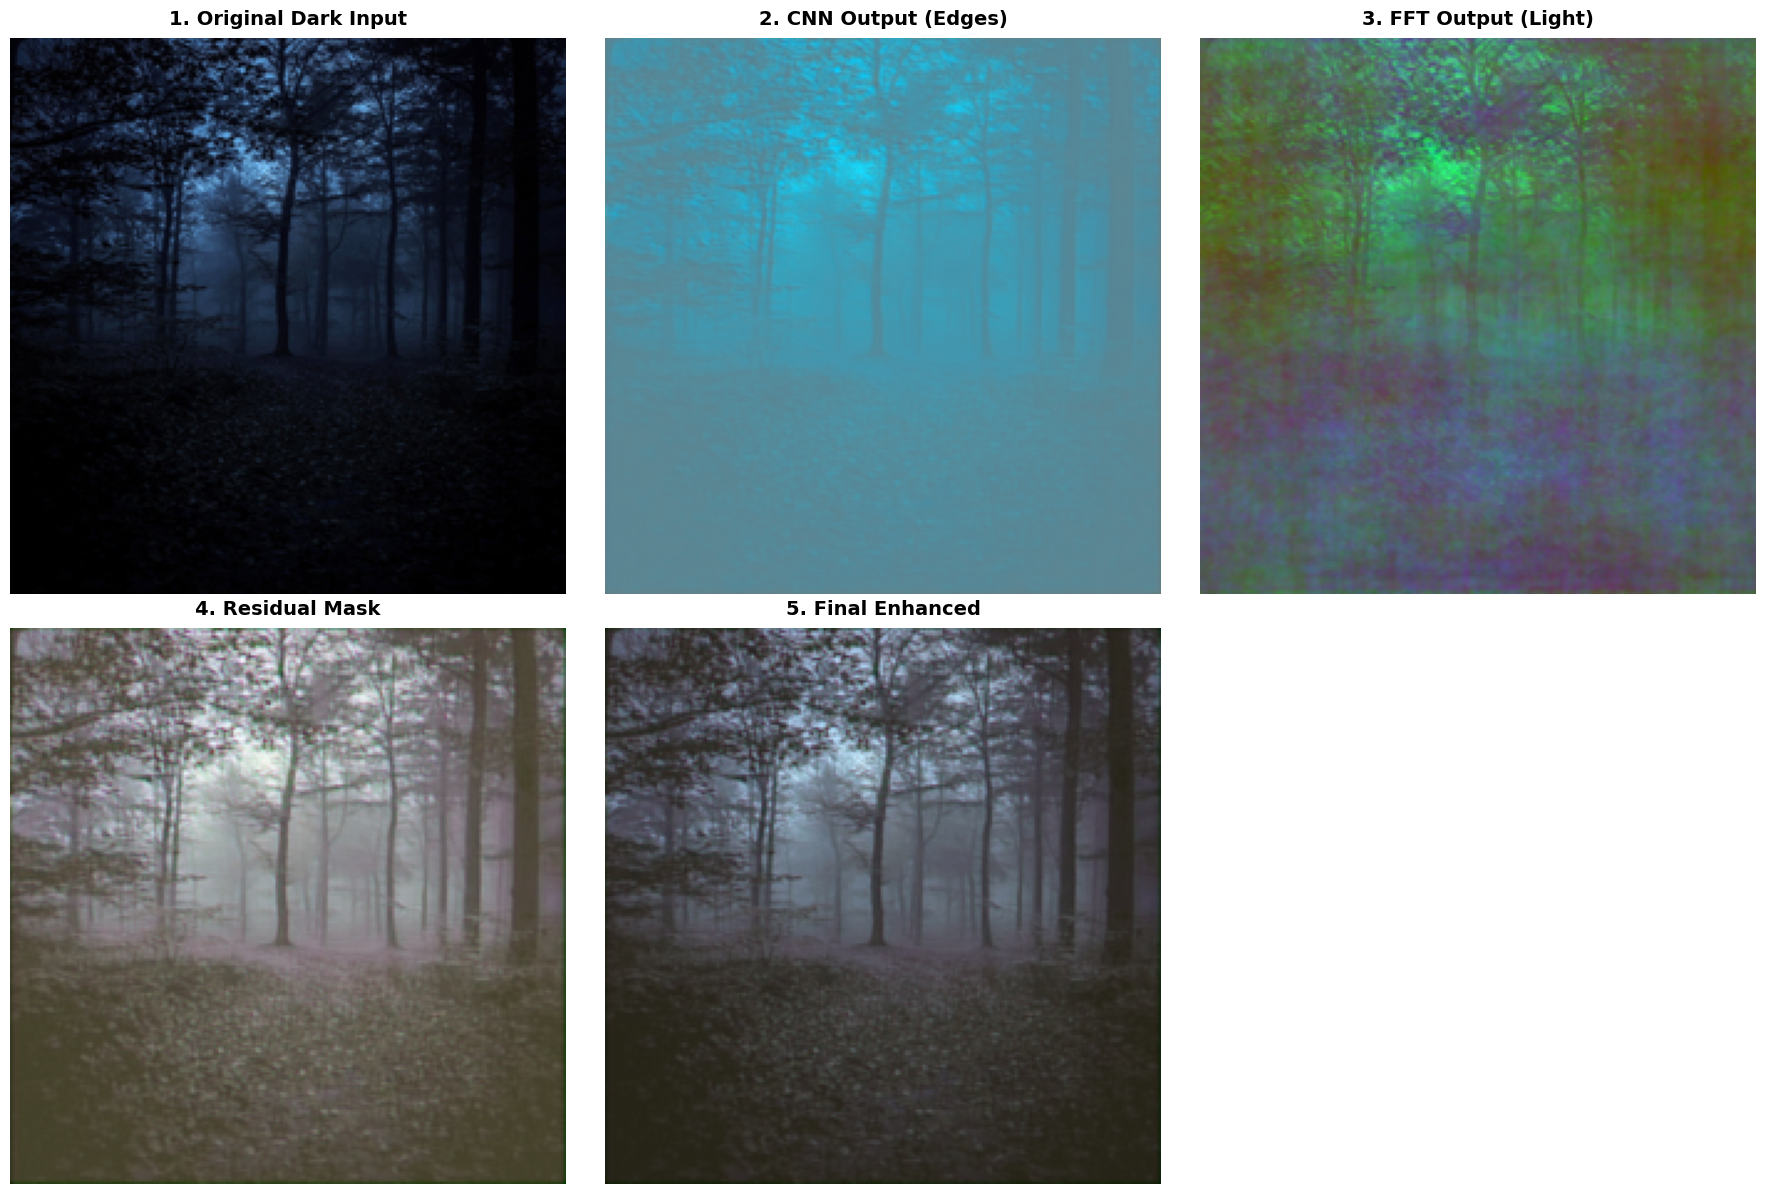

In [ ]:
# ==========================================
# 🎛️ USER CONTROL PANEL
# ==========================================

# 1. Set your paths
MODEL_PATH= "../model/NanoLILY_best_weights.ckpt" 
TARGET_IMAGE = "../dataset/forest-7543646_1280.jpg"

# 2. Set your grid layout
GRID_ROWS = 2
GRID_COLS = 3
FIG_SIZE = (18, 12)

# 3. Run the visualization
visualize_nanolily_branches(
    image_path=TARGET_IMAGE, 
    ckpt_path=MODEL_PATH, 
    rows=GRID_ROWS, 
    cols=GRID_COLS, 
    figsize=FIG_SIZE
)